In [2]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

# https://nextjournal.com/gkoehler/pytorch-mnist

In [3]:
batch_size_train = 64

In [4]:
batch_size_test = 500
transform = transforms.Compose([
    transforms.ToTensor(), # Transform to tensor, so scale data to [0.1] range
    transforms.Normalize((0.1307,),(0.3081,)) # Scale to have zero mean and standard deviation. Values of mean and STD taken as given.
])

In [5]:
# Load train data
train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', 
                                                                      train=True, download=True, 
                                                                      transform=transform),
                                                                      batch_size=batch_size_train, shuffle=True)

In [6]:
# Load test data
test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', 
                                                                      train=False, download=True, 
                                                                      transform=transform),
                                                                      batch_size=batch_size_test, shuffle=True)

In [7]:
# Get a batch of the test data. Shape shold be %batch_size_test, 1, 28, 28
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [8]:
example_data.shape

torch.Size([500, 1, 28, 28])

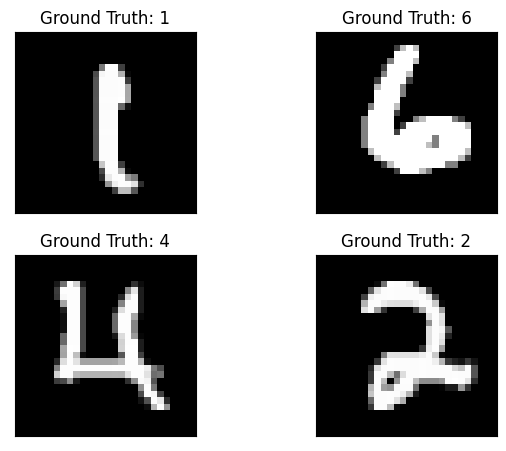

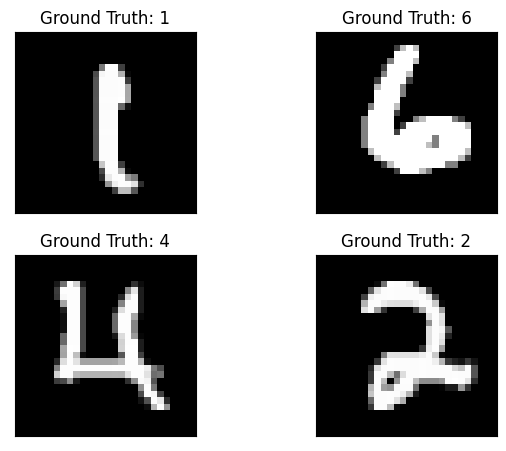

In [9]:
# Print examples of the handwritten digits and the targets (ground truth)
fig = plt.figure()
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [45]:
class DigitClassifier(nn.Module):
    
    def __init__(self) -> None:
        super(DigitClassifier, self).__init__()

    def forward(self, x):
        raise NotImplementedError("Subclasses must implement forward method") 

    def train_model(self, train_loader, optimizer, criterion, num_epochs=10, verbose=True):
        for epoch in range(num_epochs):
            running_loss = 0.0
            for images, labels in train_loader:
                optimizer.zero_grad()  # Reset gradients
                outputs = self(images)  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
                loss.backward()  # Backpropagation
                optimizer.step()  # Update weights

                running_loss += loss.item()
            if verbose:
                print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")
        if verbose:
            print("Training Complete!")

    def test_model(self, test_loader, verbose=True):
        correct = 0
        total = 0

        self.eval()

        with torch.no_grad():  # No need to track gradients
            for images, labels in test_loader:
                outputs = self(images)
                _, predicted = torch.max(outputs, 1)  # Get class with highest probability
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        
        if verbose:
            print(f"Test Accuracy: {accuracy:.2f}%")



In [46]:
class LinearDigitClassifier(DigitClassifier):
    
    def __init__(self) -> None:
        super(LinearDigitClassifier, self).__init__()

        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return F.log_softmax(x, -1)


In [ ]:
class CNNDigitClassifier(DigitClassifier):
    
    def __init__(self) -> None:
        super(CNNDigitClassifier, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, -1)

In [57]:
network = CNNDigitClassifier()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

In [58]:
network

CNNDigitClassifier(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [59]:
network.train_model(train_loader, optimizer, criterion, 5)

C:\Users\MasterK\AppData\Local\Temp\ipykernel_44932\1367609531.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Epoch 1, Loss: 0.9239228421341635
Epoch 2, Loss: 0.40360766401423065
Epoch 3, Loss: 0.31839354194875463
Epoch 4, Loss: 0.2721866516432147
Epoch 5, Loss: 0.2376436760732487
Training Complete!


In [61]:
network.test_model(test_loader)

C:\Users\MasterK\AppData\Local\Temp\ipykernel_44932\1367609531.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Test Accuracy: 97.64%


C:\Users\MasterK\AppData\Local\Temp\ipykernel_44932\1367609531.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


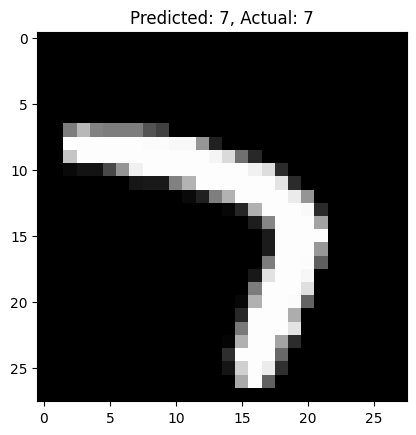

In [60]:
# Get a random test image
images, labels = next(iter(test_loader))
image = images[0].numpy().squeeze()

# Get prediction
output = network(images[0].unsqueeze(0))
_, predicted = torch.max(output, 1)

# Show image and prediction
plt.imshow(image, cmap="gray")
plt.title(f"Predicted: {predicted.item()}, Actual: {labels[0].item()}")
plt.show()

In [89]:
torch.save(network.state_dict(), "mnist_model.pth")

In [96]:
# from PIL import Image 
# import PIL 

# im1 = Image.open("image1.png") 
# # Get prediction
# logits = network(transforms.ToTensor()(im1).unsqueeze(0))
# probs = F.softmax(logits, dim=1)
# _, predicted = torch.max(probs, dim=1)

# # Show image and prediction
# plt.imshow(im1, cmap="gray")
# plt.title(f"Predicted: {predicted.item()}, Actual: {labels[0].item()}")
# plt.show()
# print(probs)